# Computer Vision
In this project, we'll train a ResNet based neural network to predict a persons age from a facial image. The goal is to achieve lower than 8 mean absolute error within 10 training epochs.

## Initialization

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import inspect

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

Age distribution

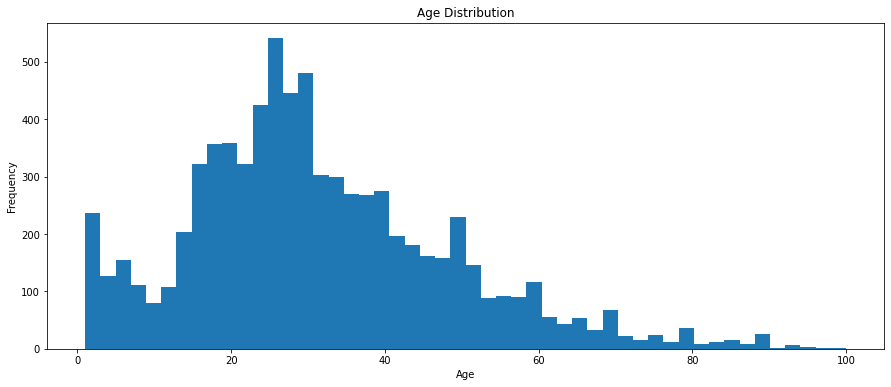

In [8]:
plt.figure(figsize=(15, 6))
plt.hist(labels['real_age'], bins=50)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Stats

In [4]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

First 15 images.

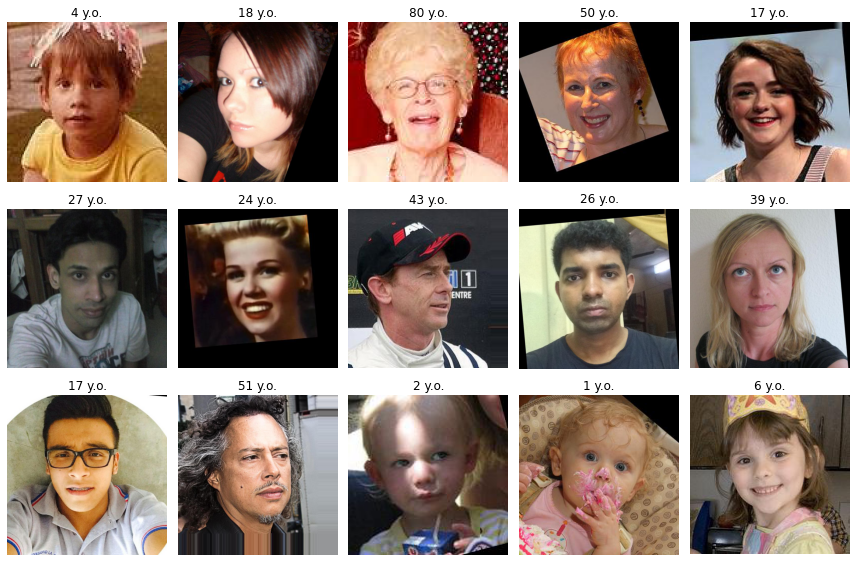

In [5]:
plt.figure(figsize=(12, 8))
for i in range (15):
    plt.subplot(3, 5, i+1)
    img = Image.open('/datasets/faces/final_files/'+labels.loc[i, 'file_name'])
    plt.title(f"{labels.loc[i, 'real_age']} y.o.")
    plt.imshow(img)
    plt.axis(False)
plt.tight_layout()
plt.show()

### Findings

Age distribution is reasonable and labels seem to match the photos. Ages 20-30 are the most represented, which is helpful because 21 falls in this range. It looks like photos have already been cropped, so no need to worry about that.

## Modelling

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import pandas as pd

In [ ]:
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path+'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 
    
    return train_datagen_flow

In [ ]:
def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')

    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path+'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345) 
    
    return test_datagen_flow

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    optimizer = Adam(lr=0.0003)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

    return model

In [ ]:
def train_model(
    model,
    train_data,
    test_data=None,
    batch_size=None,
    epochs=10,
    steps_per_epoch=None,
    validation_steps=None,
):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

## Prepare the Script to Run on the GPU Platform

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""



with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

The output from the GPU platform.

```
2022-07-04 02:25:33.348567: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-07-04 02:25:33.555812: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-07-04 02:25:37.931658: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-04 02:25:38.557892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-04 02:25:38.557969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-04 02:25:38.558002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-04 02:25:38.647881: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-04 02:25:38.663220: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-07-04 02:25:38.983899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-07-04 02:25:39.022094: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-07-04 02:25:39.022248: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-07-04 02:25:39.026863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-04 02:25:39.027261: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-07-04 02:25:39.079263: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-07-04 02:25:39.081287: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x506d4d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-04 02:25:39.081314: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-04 02:25:39.311836: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x50f34f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-04 02:25:39.311879: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-07-04 02:25:39.314291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-04 02:25:39.314362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-04 02:25:39.314375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-04 02:25:39.314406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-04 02:25:39.314418: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-07-04 02:25:39.314428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-07-04 02:25:39.314439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-07-04 02:25:39.314447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-07-04 02:25:39.318898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-04 02:25:39.320650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-04 02:25:42.694239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-07-04 02:25:42.694288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-07-04 02:25:42.694297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-07-04 02:25:42.700409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-07-04 02:26:07.733221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-04 02:26:10.026719: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 219.1569 - mean_absolute_error: 10.8251 - val_loss: 574.5958 - val_mean_absolute_error: 18.9433
Epoch 2/10
178/178 - 36s - loss: 81.1699 - mean_absolute_error: 6.8486 - val_loss: 443.3396 - val_mean_absolute_error: 15.9526
Epoch 3/10
178/178 - 37s - loss: 50.0540 - mean_absolute_error: 5.4231 - val_loss: 283.9839 - val_mean_absolute_error: 12.5993
Epoch 4/10
178/178 - 37s - loss: 28.5424 - mean_absolute_error: 4.1134 - val_loss: 131.8753 - val_mean_absolute_error: 8.5831
Epoch 5/10
178/178 - 36s - loss: 22.8526 - mean_absolute_error: 3.6986 - val_loss: 105.9378 - val_mean_absolute_error: 8.0310
Epoch 6/10
178/178 - 37s - loss: 16.6120 - mean_absolute_error: 3.1056 - val_loss: 72.9936 - val_mean_absolute_error: 6.3751
Epoch 7/10
178/178 - 37s - loss: 12.1788 - mean_absolute_error: 2.6562 - val_loss: 73.2934 - val_mean_absolute_error: 6.3803
Epoch 8/10
178/178 - 37s - loss: 10.8673 - mean_absolute_error: 2.5054 - val_loss: 81.2413 - val_mean_absolute_error: 7.0040
Epoch 9/10
178/178 - 37s - loss: 9.2310 - mean_absolute_error: 2.2911 - val_loss: 73.8362 - val_mean_absolute_error: 6.4329
Epoch 10/10
178/178 - 36s - loss: 8.2285 - mean_absolute_error: 2.1868 - val_loss: 65.7905 - val_mean_absolute_error: 6.1319
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 65.7905 - mean_absolute_error: 6.1319
Test MAE: 6.1319
```

## Conclusions

In this project, we build a neural network model for a regression task of inferring people's age from face photos. We used RESNET50 with initial pre-trained weights based on imagenet data as the backbone of our model and managed to get a mean absolute error of below 8 within 6 epochs, finishing at 6.13 after all 10 prescribed epochs were completed. This should answer the needs of the customer. Face recognition can achieve even more business tasks in retail, like tracking customer demographics, or to recognize response to products with facial expressions, or for security with biometric identification.  